# Jupyter Python And R Demo

Although all the code cells in a Jupyter notebook are attached to the same computational kernel, as with Rmd notebooks in RStudio, there are ways that we can finesse things to allow us to write, and run R code within Python code cells.

But first, let's have a look at some Python code, some notebook features that work with a Pyhton kernel, and some packages used for wrangling data.

## Crunching Data With `pandas`

One popular tool for crunching tabular data is *pandas* package:

In [1]:
import pandas as pd

df = pd.DataFrame({'a':[1,2,3], 'b':[4,5,6]})
df

a  b
0  1  4
1  2  5
2  3  6

We can load data in from data files and URLs in a wide varoety of formats: CSV, Excel scpreadsheets, JSON data, HTML tables and more.

In [2]:
import pyreadr

mtcars_py = pyreadr.read_r('mtcars.RData')
mtcars_py['mtcars'].head()

mpg  cyl   disp     hp  drat     wt   qsec   vs   am  gear  carb
0  21.0  6.0  160.0  110.0  3.90  2.620  16.46  0.0  1.0   4.0   4.0
1  21.0  6.0  160.0  110.0  3.90  2.875  17.02  0.0  1.0   4.0   4.0
2  22.8  4.0  108.0   93.0  3.85  2.320  18.61  1.0  1.0   4.0   1.0
3  21.4  6.0  258.0  110.0  3.08  3.215  19.44  1.0  0.0   3.0   1.0
4  18.7  8.0  360.0  175.0  3.15  3.440  17.02  0.0  0.0   3.0   2.0

The `pyreadr` package will also write `.Rds` and `.RData` files.

With data in a data frame, we can plot from it directly:

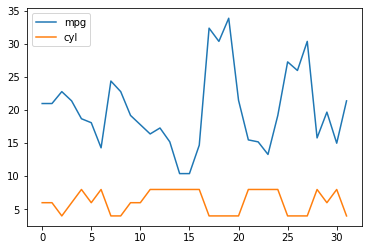

In [3]:
mtcars_py['mtcars'][['mpg', 'cyl']].plot();

A range of chart types are supported:

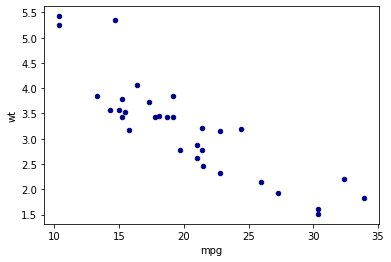

In [4]:
mtcars_py['mtcars'].plot.scatter(x='mpg', y='wt', c='DarkBlue');

The *pandas* plotting support is made even more interesting by it's ability to support a range of plotting engines on the backend. For example, if you want to generate interactive charts using plotly, we can just enable the appropriate backend and replot the chart:

In [5]:
pd.options.plotting.backend = "plotly"

mtcars_py['mtcars'].plot.scatter(x='mpg', y='wt', c='DarkBlue')

As in the R-verse, there are lots of alternatives to "native" plotting. The `seaborn` package, for example, builds up a more powerful range of statistical chart types from the same underlying core `matplotlib` graphics used by the native *pandas* plotting methods.

As with `ggplot2`, the `seaborn` package provides access to datasets we can try the charts out with, although it should be noted that these are not part of the package distribution, but instead are retrieved from an online location when the dataset is requested (so you need a web connection...):

In [6]:
import seaborn as sns
sns.set(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

fmri.head()

subject  timepoint event    region    signal
0     s13         18  stim  parietal -0.017552
1      s5         14  stim  parietal -0.080883
2     s12         18  stim  parietal -0.081033
3     s11         18  stim  parietal -0.046134
4     s10         18  stim  parietal -0.037970

One thing to note about `seaborn` is that it is a *statistical charts* package, which means it can do the necessary stats on your data as part of the chart production:

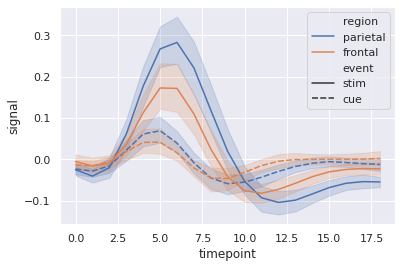

In [7]:
# Plot the responses for different events and regions
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri);

Charts on charts also come for free, as do a range of themes...

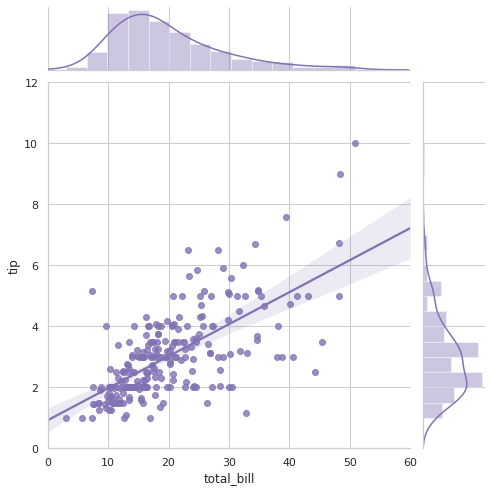

In [8]:
sns.set(style="whitegrid")

tips = sns.load_dataset("tips")

sns.jointplot("total_bill", "tip", data=tips,
                  kind="reg", truncate=False,
                  xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)

## Added Interactivity

Shiny makes creating interactive tools quite easy in an R context, so how do Jupyter notebooks compare?

The `ipywidgets` package provides a range of widget types, along with tools that can generate type sensitive widgets for you automatically.

For example, consider the following function:

In [9]:
%matplotlib inline
from ipywidgets import interact, interact_manual
import numpy as np


def signal( f1=440, f2=0, samplerate = 44100, duration = 0.01, colour='blue'):
    """Generate a dataframe containining wave data."""
    def g(f):
        samples = np.arange(duration * samplerate) / samplerate
        return np.sin(2 * np.pi * f * samples)
    
    return pd.DataFrame({'s':g(f1) + g(f2)})

signal().plot()

We can make it interactive by generating sliders to change the frequencies:

In [10]:
@interact()
#@interact_manual
def signalplot(f1=440, f2=440):
    """Plot the wave..."""
    display(signal(f1, f2).plot())

interactive(children=(IntSlider(value=440, description='f1', max=1320, min=-440), IntSlider(value=440, descrip…

We don't just have to look at the numbers as a time series, of course....

In [11]:
from IPython.display import Audio

rate = 44100 # sampling rate of the tone

#Generate the tone and play it through a notebook embedded audio player
Audio(signal(duration=2, samplerate=rate)['s'].tolist(), rate=rate, autoplay=False)

And we can easily widgetise that...

In [12]:
@interact
def audiomix(f1=400,f2=500):
    s = signal(f1=f1, f2=f2, duration=2, samplerate=rate)
    display(s.head(400).plot())
    display(Audio(s['s'].tolist(), rate=rate, autoplay=False))

interactive(children=(IntSlider(value=400, description='f1', max=1200, min=-400), IntSlider(value=500, descrip…

Another nice feature of `ipywidgets` is that you can synchronise Javascript and Python state, which means you can manipulate the data in the Javascript UI and have that updated state available to you in the Pyhton backend.

## Magic

Jupyter notebook Pyhton cells actually run against an IPyhton (interactive Pyhton) interpreter. As well as executing Pyhton code, we can also run magic... (These are sort of macros...)

In [13]:
# Load in the rpy magics...
%load_ext rpy2.ipython

In [14]:
# Something I spotted in passing that mentiined it started an R session
#I don't think we need it for anything though...
#import rpy2.robjects as robjects

We can now prefix a code cell with `%%R` and the code will actually be sent via the Pyhton interpreter to an R interpreter:

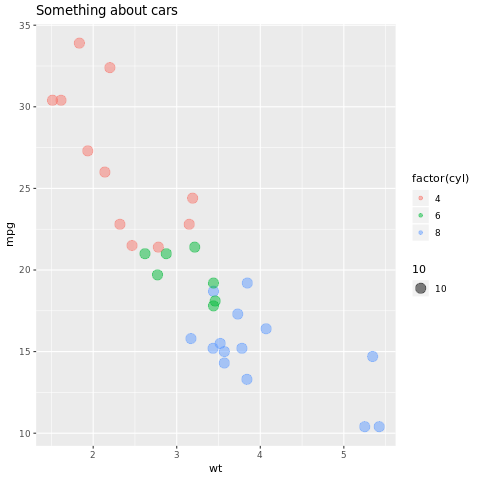

In [15]:
%%R
suppressMessages(library(ggplot2))

data(mtcars, package="datasets")

p <- ggplot(mtcars) +
     aes_string(x='wt', y='mpg', col='factor(cyl)', size=10) +
     geom_point(alpha = 0.5) +
     ggtitle('Something about cars')

p

After working in an R space, we can pull the data back out from it and into the Python context. For example:

In [16]:
%%R -o my_r_tibble -o my_r_list

library(tibble)

my_r_df = iris
my_r_tibble = as_tibble(iris)

my_r_list = c('1', '2', '3', '4', '5')

We said we wanted the list to be output (`-o`), so here it is:

In [17]:
my_r_list

array(['1', '2', '3', '4', '5'], dtype='<U1')

And the tibble we asked for is converted to a *pandas* dataframe:

In [18]:
my_r_tibble.head()

Sepal.Length  Sepal.Width  Petal.Length  Petal.Width Species
1           5.1          3.5           1.4          0.2  setosa
2           4.9          3.0           1.4          0.2  setosa
3           4.7          3.2           1.3          0.2  setosa
4           4.6          3.1           1.5          0.2  setosa
5           5.0          3.6           1.4          0.2  setosa

We did not pass the dataframe out though...

In [19]:
#my_r_df

NameError: name 'my_r_df' is not defined

As well as getting data out of the R space and into the Pyhton space, we can go the other ay, and pass Python data into (`-i`) the R space:

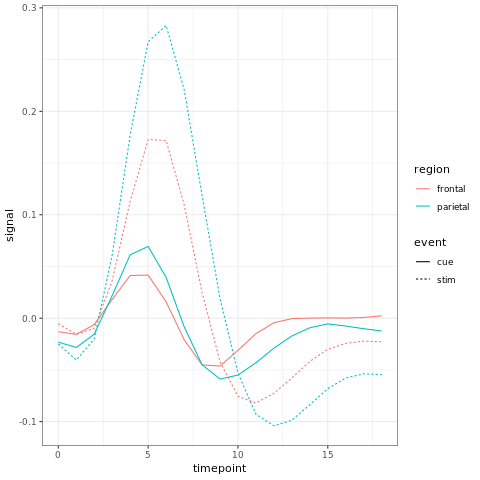

In [20]:
%%R -i fmri

ggplot(fmri) +
    aes(x=timepoint, y=signal, col=region, linetype=event) +
    stat_summary(geom="line", fun.y=mean) +
    theme_bw()

## And finally...

There's a load of crazy Python packages out there (as there is R packages), providing a wealth of tooling to support particular applications. Here are  few crazy examples I like...

### Symbolic Computation

Think Mathematica... write equations naturally and evaluate them numerically...

Let's define some symbols...

In [21]:
from sympy import symbols
x, y, z = symbols('x y z')

Suppose we have a particular expression:

In [23]:
from sympy import sqrt

expression = sqrt(1/x)
expression

sqrt(1/x)

And we want to integrate it:

In [24]:
from sympy import Integral

integral_indefinite = Integral(expression, x)
integral_indefinite

Integral(sqrt(1/x), x)

How do we write that in *LaTeX*?

In [25]:
from sympy import latex

print(latex(integral_indefinite))

\int \sqrt{\frac{1}{x}}\, dx


How about we actually evaluate it?

In [26]:
integral_indefinite.doit()

2*x*sqrt(1/x)

What about the definite form:

In [28]:
from sympy import pi

integral_definite = Integral(expression, (x, 0, pi))
integral_definite

Integral(sqrt(1/x), (x, 0, pi))

And this evaluates as;

In [29]:
integral_definite.doit()

2*sqrt(pi)

We can also be more direct in evaulating an expression. For example:

In [30]:
from sympy import integrate

integrate(expression, x)

2*x*sqrt(1/x)

We can define a whole range of expressions, such as this summation:

In [32]:
from sympy import Sum, oo

i = symbols('i')

mysum = Sum(1/i**2, (i, 1, oo))

mysum

Sum(i**(-2), (i, 1, oo))

And then evaluate it symbolically:

In [33]:
mysum.doit()

pi**2/6

Or numerically:

In [34]:
mysum.evalf()

1.64493406684823

There are tools available for simplifying expressions too. For example:

In [35]:
from sympy import simplify, sin, cos

x = symbols('x')
expr = sin(x) * cos(x)
simplify(expr)

sin(2*x)/2

In what is probably an abuse of the way `sympy` is supposed to be used, we can also express that as an equation:

In [37]:
from sympy import Eq

Eq(expr, simplify(expr))

Eq(sin(x)*cos(x), sin(2*x)/2)

And get the *LaTeX*...

In [38]:
print(latex(Eq(expr, simplify(expr))))

\sin{\left(x \right)} \cos{\left(x \right)} = \frac{\sin{\left(2 x \right)}}{2}


There's lots more you can do... a handy quickstart reference is https://pythonforundergradengineers.com/sympy-expressions-and-equations.html

## Other Examples

Lots of other examples of things we can do in notebook, may of them graphically and interactively, here: https://github.com/psychemedia/showntell/blob/master/presentations/dept%20talk/Department%20Talk.ipynb

Examples include, but aren't limited to:

- drawing electrical circuit diagrams and modelling their behaviour;
- 3d molecular visualisations;
- drawing geometry diagrams;
- musical score visualisation and analysis;
- text analysis and visualisation.